# Spam Detection

## Importing Important libraries

In [2]:
!pip install optuna --q # For tuning hyperparameters

In [3]:
!pip3 install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.2 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip3 install contractions
import contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 10.0 MB/s eta 0:00:00


In [5]:
# Basic modules for reading and manipulating the dataset. 
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP tasks
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

# all the required models 
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# for model evaluation
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


# for hyperparameter tuning
import optuna

# to save the required files
import pickle

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

In [6]:
data=pd.read_csv('../input/email-spam-dataset/completeSpamAssassin.csv')
data.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [7]:
data.shape

(6046, 3)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [9]:
data.describe()

,Unnamed: 0,Label
count,6046.000000,6046.000000
mean,3022.500000,0.313596
std,1745.474195,0.463993
min,0.000000,0.000000
25%,1511.250000,0.000000
50%,3022.500000,0.000000
75%,4533.750000,1.000000
max,6045.000000,1.000000


In [10]:
data['Label'].value_counts()

0    4150
1    1896
Name: Label, dtype: int64

In [11]:
data.isnull().sum()

Unnamed: 0    0
Body          1
Label         0
dtype: int64

In [12]:
data.duplicated().sum()

0

In [13]:
data.dropna(inplace=True)

## Observation
### 1. Data contains 6046 rows and 3 columns
### 2. It has 1 string/object column, and one categorical column in int format
### 3. There's only 1 null value present
### 4. There are no duplicate values present within data
### 5. We dropped the one row with the null value 

## Now Lets do some Data Preprocessing
Step 1: Contraction Mapping / Expanding Contractions

Step 2: Tokenization

Step 3: Noise Cleaning - spacing, special characters, lowercasing

Step 4: Spell Checking

Step 5: ‘Stop Words’ Identification

Step 6: Stemming/Lemmatization

Step 7: Tokenization/Vectorization (Countvectororiser/TFID)

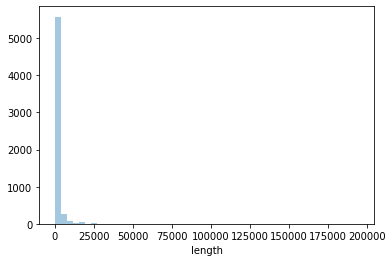

In [14]:
data["length"] = data["Body"].apply(len)
sns.distplot(data["length"], kde=False);

## Step 1: Contraction Mapping / Expanding Contractions
Contractions are words that we write with an apostrophe. Examples of contractions are words like “ain’t” or “aren’t”. Since we want to standardize our text, it makes sense to expand these contractions. We are going to add a new column to our dataframe called “no_contract” and apply a lambda function to the "msg" field which will expand any contractions

In [15]:
data.iloc[0]["Body"]

"\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?Life Quote Savings\nEnsuring your \n      family's financial security is very important. Life Quote Savings makes \n      buying life insurance simple and affordable. We Provide FREE Access to The \n      Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and \n            SAVES you money! Let us help you get started with the best values in \n            the country on new coverage. You can SAVE hundreds or even thousands \n            of dollars by requesting a FREE quote from Lifequote Savings. Our \n            service will take you less than 5 minutes to complete. Shop and \n            compare. SAVE up to 70% on all types of Life insurance! Click Here For Your \n            Free Quote!Protecting your family is the best investment you'll ever \n          make!\nIf you are in receipt of this email \n      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If

In [16]:
data['no_contract'] = data['Body'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [17]:
data.head()

,Unnamed: 0,Body,Label,length,no_contract
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www..."
3,3,##############################################...,1,2863,[#############################################...
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli..."


Also, we would want the expanded contractions to be tokenized separately, therefore we convert the lists under the "no_contract" column back into strings

In [18]:
data["polish_Body"] = [' '.join(map(str, l)) for l in data['no_contract']]
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...
3,3,##############################################...,1,2863,[#############################################...,##############################################...
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...


## Step 2: Tokenization
We will begin by breaking apart the corpus into a vocabulary of unique terms, and this is called tokanization.

We can tokenize individual terms and generate what's called a bag of words model. You may notice this model has a glaring pitfall: it fails to capture the innate structure of human language. We can also tokenize using nltk, which is the leading platform for building Python programs to work with human language data

In [19]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
txt=data['polish_Body'][0]
print(word_tokenize(txt))

['Save', 'up', 'to', '70', '%', 'on', 'Life', 'Insurance', '.', 'Why', 'Spend', 'More', 'Than', 'You', 'Have', 'To', '?', 'Life', 'Quote', 'Savings', 'Ensuring', 'your', 'family', "'s", 'financial', 'security', 'is', 'very', 'important', '.', 'Life', 'Quote', 'Savings', 'makes', 'buying', 'life', 'insurance', 'simple', 'and', 'affordable', '.', 'We', 'Provide', 'FREE', 'Access', 'to', 'The', 'Very', 'Best', 'Companies', 'and', 'The', 'Lowest', 'Rates.Life', 'Quote', 'Savings', 'is', 'FAST', ',', 'EASY', 'and', 'SAVES', 'you', 'money', '!', 'Let', 'us', 'help', 'you', 'get', 'started', 'with', 'the', 'best', 'values', 'in', 'the', 'country', 'on', 'new', 'coverage', '.', 'You', 'can', 'SAVE', 'hundreds', 'or', 'even', 'thousands', 'of', 'dollars', 'by', 'requesting', 'a', 'FREE', 'quote', 'from', 'Lifequote', 'Savings', '.', 'Our', 'service', 'will', 'take', 'you', 'less', 'than', '5', 'minutes', 'to', 'complete', '.', 'Shop', 'and', 'compare', '.', 'SAVE', 'up', 'to', '70', '%', 'on', 

In [21]:
data['tokenized'] = data['polish_Body'].apply(word_tokenize)
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),..."


Step 3: Noise Cleaning - spacing, special characters, lowercasing

### Step 3: Noise Cleaning - spacing, special characters, lowercasing

In [22]:
# return a random sample of items from an axis of object.
# You can use `random_state` for reproducibility
data.sample(frac=0.05)

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized
2275,2275,\nOf course they had to do this AFTER we purca...,0,576,"[Of, course, they, had, to, do, this, AFTER, w...",Of course they had to do this AFTER we purcahs...,"[Of, course, they, had, to, do, this, AFTER, w..."
1052,1052,Do you Have an Epson or Canon Printer?\nÂ \nÂ ...,1,1018,"[Do, you, Have, an, Epson, or, Canon, Printer?...",Do you Have an Epson or Canon Printer? Â Â Do ...,"[Do, you, Have, an, Epson, or, Canon, Printer,..."
1502,1502,empty,1,5,[empty],empty,[empty]
1691,1691,Norton \n SystemWorks 2002 Software S...,1,952,"[Norton, SystemWorks, 2002, Software, Suite, P...",Norton SystemWorks 2002 Software Suite Profess...,"[Norton, SystemWorks, 2002, Software, Suite, P..."
685,685,"Hello,I found your opportunity posted at: \nht...",1,462,"[Hello,I, found, your, opportunity, posted, at...","Hello,I found your opportunity posted at: http...","[Hello, ,, I, found, your, opportunity, posted..."
...,...,...,...,...,...,...,...
2718,2718,\n----- Original Message -----\nFrom: > the pa...,0,506,"[-----, Original, Message, -----, From:, >, th...",----- Original Message ----- From: > the parti...,"[--, --, -, Original, Message, --, --, -, From..."
5657,5657,"On Mon, 2002-08-19 at 22:34, Angles Puglisi wr...",0,1469,"[On, Mon,, 2002-08-19, at, 22:34,, Angles, Pug...","On Mon, 2002-08-19 at 22:34, Angles Puglisi wr...","[On, Mon, ,, 2002-08-19, at, 22:34, ,, Angles,..."
1004,1004,"DEAR HOMEOWNER,main { font-family: Verdana, A...",1,1507,"[DEAR, HOMEOWNER,main, {, font-family:, Verdan...","DEAR HOMEOWNER,main { font-family: Verdana, Ar...","[DEAR, HOMEOWNER, ,, main, {, font-family, :, ..."
5975,5975,empty,0,5,[empty],empty,[empty]


Clearly there's a lot going on here: digits, gratuitous whitespace, and all varieties of punctuation. Some terms are randomly capitalized, others are in all-caps. Since these terms might show up in any one of the training examples in countless forms, we need a way to ensure each training example is on equal footing via a preprocessing step called normalization. This form of noise cleaning takes care of spacing and any special characters.

Transforming all words to lowercase is also a very common pre-processing step. In this case, we will once again append a new column named “lower” to the dataframe which will transform all the tokenized words into lowercase. However, because we have to iterate over multiple words we will use a simple for-loop within a lambda function to apply the “lower” function to each word.

In [23]:
data['lower'] = data['tokenized'].apply(lambda x: [word.lower() for word in x])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),..."


Next, we'll remove all punctuation since they serve little value once we begin to analyze our data. Continuing the previous pattern, we will create a new column which has the punctuation removed. We will again utilize a for-loop within a lambda function to iterate over the tokens but this time using an IF condition to only output alpha characters

In [24]:
punc = string.punctuation
data['no_punc'] = data['lower'].apply(lambda x: [word for word in x if word not in punc])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www...."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www...."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,..."


## Step 4: Spell Checking
For spell checking, we will use Microsoft's TextBlob, which is a simple spelling correction mechanism

In [25]:
from spellchecker import SpellChecker
spell = SpellChecker()

# data['corrected'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
# data.head()


### Step 5: Stop Words Identification
Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out.
We are going to add a new column “no_stopwords” which will remove the stopwords from the “no_punc” column since it has been tokenized, had been converted to lowercase and punctuation was removed. Once again a for-loop within a lambda function will iterate over the tokens in “no_punc” and only return the tokens which do not exist in our “stop_words” variable.


In [26]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data['stopwords_removed'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo..."


In [28]:
nltk.download('averaged_perceptron_tagger')
data['pos_tags'] = data['stopwords_removed'].apply(nltk.tag.pos_tag)
data.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C..."


In [29]:
nltk.download('omw-1.4')
nltk.download('wordnet')
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
data['wordnet_pos'] = data['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
data.head()

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ..."


# Step 6: Stemming/Lemmatization
The idea of stemming is to reduce different forms of word usage into its root word. For example, “drive”, “drove”, “driving”, “driven”, “driver” are derivatives of the word “drive” and very often researchers want to remove this variability from their corpus. Compared to lemmatization, stemming is certainly the less complicated method but it often does not produce a dictionary-specific morphological root of the word. In other words, stemming the word “pies” will often produce a root of “pi” whereas lemmatization will find the morphological root of “pie”.
Instead of taking the easy way out with stemming, let’s apply lemmatization to our data but it requires some additional steps compared to stemming. First, we have to apply parts of speech tags, in other words, determine the part of speech (ie. noun, verb, adverb, etc.) for each word


In [30]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
data['lemmatized'] = data['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,1111,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,753,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,610,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
3,3,##############################################...,1,2863,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant..."
4,4,I thought you might like these:\n1) Slim Down ...,1,641,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los..."


In [31]:
data["length"] = data["lemmatized"].apply(len)
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,98,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote..."
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,83,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,67,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w..."
3,3,##############################################...,1,317,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant..."
4,4,I thought you might like these:\n1) Slim Down ...,1,63,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los..."


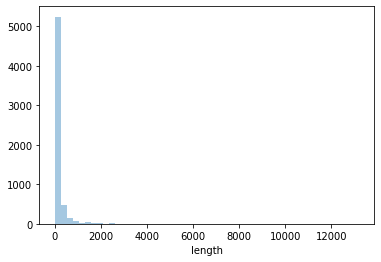

In [32]:
sns.distplot(data["length"], kde=False);

In [33]:
data['no_char'] = data['polish_Body'].apply(len)
data['no_words'] = data['polish_Body'].apply(lambda x:len(nltk.word_tokenize(x)))
data['no_sent'] = data['polish_Body'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [34]:
data.to_csv("Final_dataset.csv")

### This show the partition of the data using pie-plot

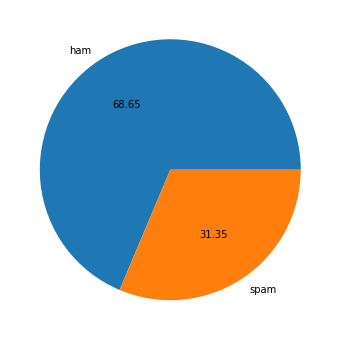

In [35]:
plt.figure(figsize=(12,6))
plt.pie(data['Label'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

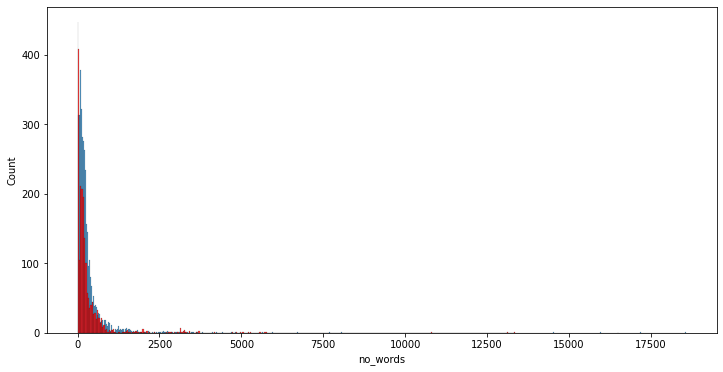

In [36]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['Label'] == 0]['no_words'])
sns.histplot(data[data['Label'] == 1]['no_words'], color='red')
plt.show()

### this is the relation between the labels and the features present in the dataframe

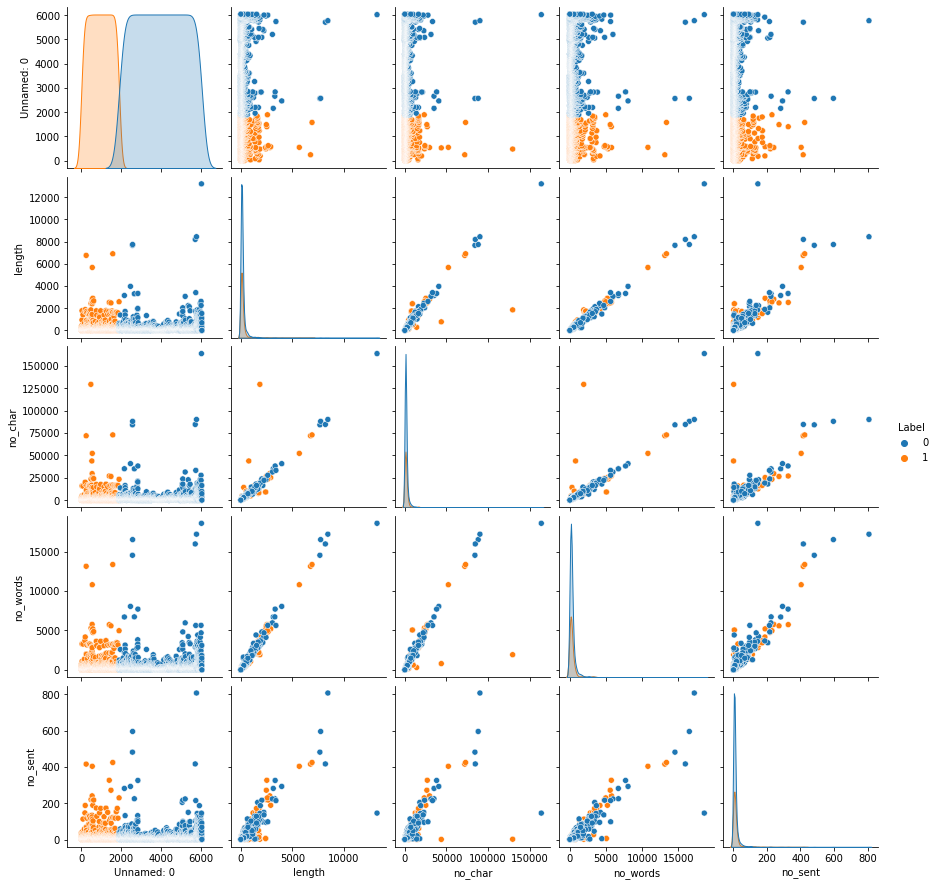

In [37]:
sns.pairplot(data, hue='Label')
plt.show()

In [38]:
data['lem_txt'] = data['lemmatized'].apply(lambda x:" ".join(x) )
data.head()

,Unnamed: 0,Body,Label,length,no_contract,polish_Body,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized,no_char,no_words,no_sent,lem_txt
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,98,"[Save, up, to, 70%, on, Life, Insurance., Why,...",Save up to 70% on Life Insurance. Why Spend Mo...,"[Save, up, to, 70, %, on, Life, Insurance, ., ...","[save, up, to, 70, %, on, life, insurance, ., ...","[save, up, to, 70, on, life, insurance, why, s...","[save, 70, life, insurance, spend, life, quote...","[(save, VB), (70, CD), (life, NN), (insurance,...","[(save, v), (70, n), (life, n), (insurance, n)...","[save, 70, life, insurance, spend, life, quote...",973,191,12,save 70 life insurance spend life quote saving...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,83,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w...",752,139,5,1 fight risk cancer http //www.adclick.ws/p.cf...
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,67,"[1), Fight, The, Risk, of, Cancer!, http://www...",1) Fight The Risk of Cancer! http://www.adclic...,"[1, ), Fight, The, Risk, of, Cancer, !, http, ...","[1, ), fight, the, risk, of, cancer, !, http, ...","[1, fight, the, risk, of, cancer, http, //www....","[1, fight, risk, cancer, http, //www.adclick.w...","[(1, CD), (fight, NN), (risk, NN), (cancer, NN...","[(1, n), (fight, n), (risk, n), (cancer, n), (...","[1, fight, risk, cancer, http, //www.adclick.w...",610,113,4,1 fight risk cancer http //www.adclick.ws/p.cf...
3,3,##############################################...,1,317,[#############################################...,##############################################...,"[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...","[adult, club, offers, free, membership, instan...","[adult, club, offers, free, membership, instan...","[(adult, NN), (club, NN), (offers, NNS), (free...","[(adult, n), (club, n), (offers, n), (free, a)...","[adult, club, offer, free, membership, instant...",2712,690,35,adult club offer free membership instant acces...
4,4,I thought you might like these:\n1) Slim Down ...,1,63,"[I, thought, you, might, like, these:, 1), Sli...",I thought you might like these: 1) Slim Down -...,"[I, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, :, 1, ),...","[i, thought, you, might, like, these, 1, slim,...","[thought, might, like, 1, slim, guaranteed, lo...","[(thought, NN), (might, MD), (like, VB), (1, C...","[(thought, n), (might, n), (like, v), (1, n), ...","[thought, might, like, 1, slim, guarantee, los...",638,108,4,thought might like 1 slim guarantee lose 10-12...


In [39]:
spam_corpus = []
for mail in data[data['Label'] == 1]['lem_txt'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

# number of words in all spam mails
len(spam_corpus)

ham_corpus = []
for mail in data[data['Label'] == 0]['lem_txt'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

# number of words in all ham mails
len(ham_corpus)

688399

### This shows the bar-plot of top 50 words used in spam msgs

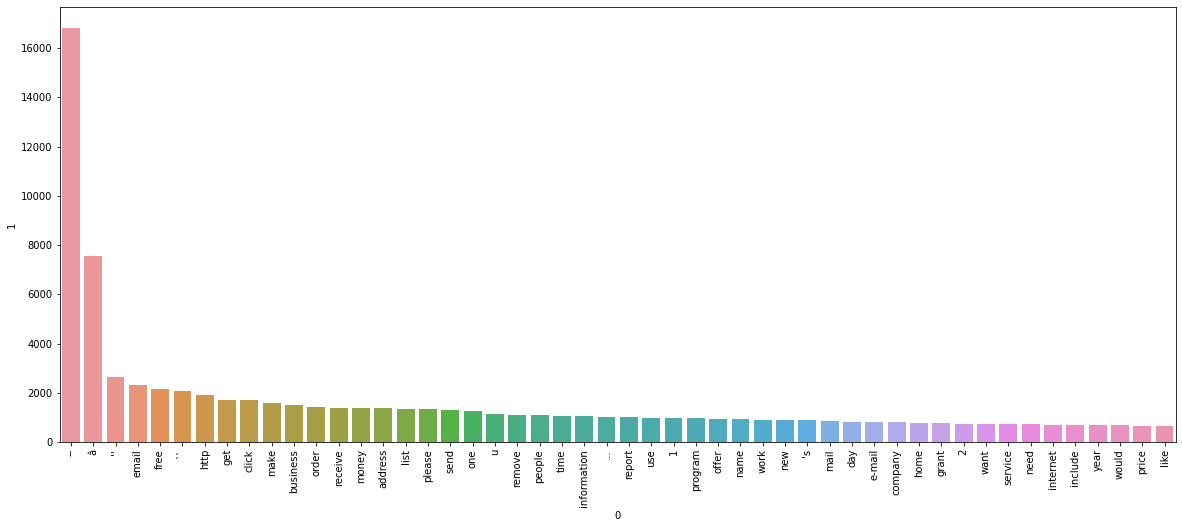

In [40]:
from collections import Counter
# top 50 most occuring words in spam mails
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(50))[0],pd.DataFrame(Counter(spam_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

### This shows the bar-plot of top 50 words used in ham msgs

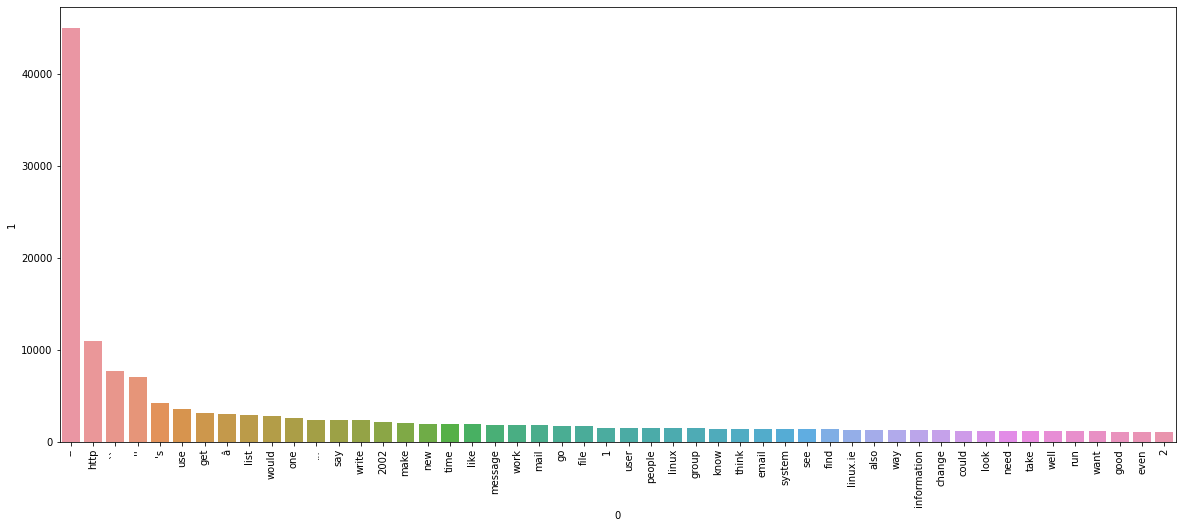

In [41]:
plt.figure(figsize=(20,8))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(50))[0],pd.DataFrame(Counter(ham_corpus).most_common(50))[1])
plt.xticks(rotation='vertical')
plt.show()

## Removing Unwanted words from the text

In [42]:
ls=Counter(ham_corpus).most_common(100)
k=[]
l=[]
for i in ls:
#     if i in Counter(spam_corpus).most_common(50):
    k.append(i[0])
    

print("\n\n\n\n\n\n\n\n")

ls=Counter(spam_corpus).most_common(100)
for i in ls:
#     if i in Counter(spam_corpus).most_common(50):
#         print(i[0],end=",")
    l.append(i[0])

# print(k,l) 
# for i in k:
#     if i in l:
#         print(i)
        

common=["--","http","``","''","'s","â","..."]
    

In [43]:
# data['lem_txt'] = data['lemmatized'].apply(lambda x:" ".join(x) )
# st=data.iloc[0]['lem_txt']
for i in common:
    data['lem_txt'] = data['lem_txt'].apply(lambda x:x.replace(i,"") )

# Train Test Split

F-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set).

Tf-idf is one of the best metrics to determine how significant a term is to a text in a series or a corpus. tf-idf is a weighting system that assigns a weight to each word in a document based on its term frequency (tf) and the reciprocal document frequency (tf) (idf). The words with higher scores of weight are deemed to be more significant.

In [44]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)
# Setting up features and target as x and y
x = tfidf.fit_transform(data['lem_txt']).toarray()
y = data['Label'].values

In [45]:
# x_demo=tfidf.fit_transform(pd.Series(data['lem_txt'][0:10])).toarray()
# x_demo.shape

In [46]:
# Splitting the testing and training sets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [47]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=0)
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
bc = BaggingClassifier(n_estimators=50, random_state=0)
etc = ExtraTreesClassifier(n_estimators=50, random_state=0)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=0)
xgb = XGBClassifier(n_estimators=50,random_state=0)
sgd = SGDClassifier(random_state=0)
cat = CatBoostClassifier(verbose=0, random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [48]:
classifiers = {
    'GaussianNB' : gnb,
    'MultinomialNB' : mnb,
    'BernoulliNB' : bnb,
    'SVC' : svc,
    'KNeighbors' : knc, 
    'DecisionTree': dtc, 
    'LogisticRegression': lrc, 
    'RandomForest': rfc, 
    'AdaBoost': abc, 
    'BaggingClassifier': bc, 
    'ExtraTreesClassifier': etc,
    'GradientBoosting': gbdt,
    'XGB': xgb,
    'SGD' : sgd,
    'Catboost' : cat,
    'LGBM' : lgbm 
}

In [49]:
def train_classifier(classifiers,x_train,y_train,x_test,y_test):
    
    classifiers.fit(x_train,y_train)
    
    y_pred = classifiers.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [50]:
# # storing accuracy and precision in list
# accuracy_scores = []
# precision_scores = []

# # training all the models on training data
# for name,classifier in classifiers.items():
    
#     current_accuracy,current_precision = train_classifier(classifier, x_train,y_train,x_test,y_test)
    
#     print("For ",name)
#     print("Accuracy - ",current_accuracy)
#     print("Precision - ",current_precision,'\n')
    
#     accuracy_scores.append(current_accuracy)
#     precision_scores.append(current_precision)

In [51]:
# performance = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
# performance

NameError: name 'accuracy_scores' is not defined

From the above model we can conclude that SGD performs better than all the other models

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn import tree
x_train,x_test,y_train,y_test = train_test_split(data['lem_txt'],y,test_size=0.2,random_state=0)
nlp_followed_by_dt = Pipeline(
    [
    ("vect", HashingVectorizer(input="content", ngram_range=(1,3))),
    ("tfidf", TfidfTransformer(use_idf=True,)),
    ("dt", SGDClassifier(random_state=0)),
#     ("dt", tree.DecisionTreeClassifier(class_weight="balanced")),
    ]
)
nlp_followed_by_dt.fit(x_train,y_train)

Pipeline(steps=[('vect', HashingVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('dt', SGDClassifier(random_state=0))])

In [53]:
nlp_followed_by_dt.predict(x_test)

array([1, 0, 1, ..., 0, 0, 0])

#### So hash vectorization befoe TFID really does some improvement in predicting. 

# Classification of Spam messages to ham.
# The main goal of a spam message is to deliver.
### 1)Make the user to know about specific service
### 2)To deliver specific file which user download like ransomware , malware etc.
### 3)To deliver spam link

## Let us now try few steps to make the spam message corrupted so that still the messages are classified as ham and deliver the content ( Note : MAy not be completely but partially)



By Removing the word in the text which cause the text to classify as spam causes us to misclassify the test as ham

### Sample model to remove the words which caouse our msg to be spam

In [114]:
spams=data[data['Label'] == 1]
spams

l=[]
ls=Counter(spam_corpus).most_common(0)
for i in ls:
    l.append(i[0])
    
for i in l:
    spams['lem_txt'] = spams['lem_txt'].apply(lambda x:x.replace(i,"") )
    
xx = tfidf.transform(spams['lem_txt']).toarray()
yy = spams['Label'].values



In [55]:
spams.iloc[0]['lem_txt']

'save 70 life insurance spend life quote saving ensure family  financial security important life quote saving make buy life insurance simple affordable provide free access best company low rates.life quote saving fast easy save money let u help get start best value country new coverage save hundred even thousand dollar request free quote lifequote saving service take less 5 minute complete shop compare save 70 type life insurance click free quote protect family best investment ever make receipt email error and/or wish remove list please click type remove reside state prohibits e-mail solicitation insurance please disregard email'

### Lets train a model on our data

In [115]:
from sklearn.calibration import CalibratedClassifierCV
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
# model=SGDClassifier(random_state=42)


lr = SGDClassifier(loss='hinge',class_weight='balanced',random_state=42)
clf =lr.fit(x_train, y_train)
clf=model.fit( x_train,y_train)
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit( x_train,y_train)

In [116]:
preds=model.predict(x_test)

## Accuracy without any modification

In [117]:
accuracy_score(y_test,preds)

0.9247311827956989

## Accuracy seems well on the data trained

#### Let start to manipulate the input email data and check-up with the accuracy

In [118]:
xx.shape

(1895, 17000)

In [119]:
data.columns

Index(['Unnamed: 0', 'Body', 'Label', 'length', 'no_contract', 'polish_Body',
       'tokenized', 'lower', 'no_punc', 'stopwords_removed', 'pos_tags',
       'wordnet_pos', 'lemmatized', 'no_char', 'no_words', 'no_sent',
       'lem_txt'],
      dtype='object')

# The preprocessor to process the input data

In [61]:
def preprcocess(mail):
    no_contract = [contractions.fix(word) for word in mail.split()]
    polish_Body = [''.join(map(str, l)) for l in no_contract]
    polish_Body=" ".join(polish_Body)
    tokenized = word_tokenize(polish_Body)
#     print(tokenized)
    lower = [word.lower() for word in tokenized]
#     print(lower)
    punc = string.punctuation
    no_punc = [word for word in lower if word not in punc]
    stopwords_removed = [word for word in no_punc if word not in stop_words]
#     print(stopwords_removed)
    pos_tags = nltk.tag.pos_tag(stopwords_removed)
    wordnet_pos = [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in pos_tags]
    lemmatized = [wnl.lemmatize(word, tag) for word, tag in wordnet_pos]
    out=" ".join(lemmatized)
    out=out.replace(" '"," ")
#     print(out)
    return out
out=preprcocess(spams.iloc[0]['Body'])

In [122]:

print("\n\n\n The original message :\n\n\n",spams.iloc[3]['Body'])

out=preprcocess(spams.iloc[3]['Body'])

xx=tfidf.transform([out]).toarray()
yy = spams.iloc[0]['Label']


# print(out)

print("First Result \n Original Result without any modification of the data :",yy)
pred_1=model.predict(xx)
print("First Result \n Predicted Result without any modification of the data :",pred_1)



l=[]
# This processor helps in removing the spam words from the msg

ls=Counter(spam_corpus).most_common(20)
for i in ls:
    l.append(i[0])

omsg=spams.iloc[3]['Body']
    
for i in l:
    omsg = omsg.replace(i,"")
    
print("\n The original message without spam messages:\n",omsg)
    
for i in l:
    out = out.replace(i,"")

xx=tfidf.transform([out]).toarray()

print("First Result \n Original Result without any modification of the data :",yy)
pred_2=model.predict(xx)
print("First Result \n Predicted Result without any modification of the data :",pred_2)
# pred_2=model.predict(xx)

print(pred_1,pred_2)






 The original message :


 ##################################################
#                                                #
#                 Adult Club                     #
#           Offers FREE Membership               #
#                                                #
##################################################>>>>>  INSTANT ACCESS TO ALL SITES NOW
>>>>>  Your User Name And Password is.
>>>>>  User Name: zzzz@spamassassin.taint.org
>>>>>  Password: 7603825 of the Best Adult Sites on the Internet for FREE!
---------------------------------------
NEWS 08/18/02
With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New
Members. Are you one of them yet???
---------------------------------------
Our Membership FAQQ. Why are you offering free access to 5 adult membership sites for free?
A. I have advertisers that pay me for ad space so you don't have to pay for membership.Q. Is it true my membership is for life?
A. Absolutely you'll n

In [124]:

print("\n\n\n The original message :\n\n\n",spams.iloc[3]['Body'])

out=preprcocess(spams.iloc[3]['Body'])

xx=tfidf.transform([out]).toarray()
yy = spams.iloc[3]['Label']


# print(out)

print("First Result \n Original Result without any modification of the data :",yy)
pred_1=model.predict(xx)
print("First Result \n Predicted Result without any modification of the data :",pred_1)



l=[]
# This processor helps in removing the spam words from the msg

ls=Counter(spam_corpus).most_common(20)
for i in ls:
    l.append(i[0])

omsg=spams.iloc[0]['Body']
    
for i in l:
    omsg = omsg.replace(i,"")
    
print("\n The original message without spam messages:\n",omsg)
    
for i in l:
    out = out.replace(i,"")

xx=tfidf.transform([out]).toarray()

print("First Result \n Original Result without any modification of the data :",yy)
pred_2=model.predict(xx)
print("First Result \n Predicted Result without any modification of the data :",pred_2)
# pred_2=model.predict(xx)

print(pred_1,pred_2)






 The original message :


 ##################################################
#                                                #
#                 Adult Club                     #
#           Offers FREE Membership               #
#                                                #
##################################################>>>>>  INSTANT ACCESS TO ALL SITES NOW
>>>>>  Your User Name And Password is.
>>>>>  User Name: zzzz@spamassassin.taint.org
>>>>>  Password: 7603825 of the Best Adult Sites on the Internet for FREE!
---------------------------------------
NEWS 08/18/02
With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New
Members. Are you one of them yet???
---------------------------------------
Our Membership FAQQ. Why are you offering free access to 5 adult membership sites for free?
A. I have advertisers that pay me for ad space so you don't have to pay for membership.Q. Is it true my membership is for life?
A. Absolutely you'll n

In [106]:
yy

1

In [128]:
txt=spams["lem_txt"]
l=[]
ls=Counter(spam_corpus).most_common(20)
for i in ls:
    l.append(i[0])
    
for i in range(len(txt)):
    for j in l:
        txt.iloc[i] = txt.iloc[i].replace(j,"") 
    
# for i in l:
#     txt = txt.replace(i,"") 
    
    
xx = tfidf.transform(txt).toarray()
yy = spams["Label"]

preds=model.predict(xx)
# txt



In [131]:
accuracy_score(yy,preds)
# accuracy_score

0.6569920844327177

# we can observe this thing caused us to decrease the accuracy to 65%

# Now we were able to decrease the accuracy to 65%; Which is an abosolute win

In [129]:
# pre

# Deployment

In [67]:
import pickle as pkl
filename = 'final_model.pkl'
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
model=SGDClassifier(random_state=0)
model.fit( x_train,y_train)
pickle.dump(model, open(filename, 'wb'))

 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(x_test)

In [68]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.9602977667493796

# The second trail is finding the weightage of each feature which we failed to retrive.

In [69]:
tfidf.inverse_transform(xx)

[array(['70', 'access', 'affordable', 'all', 'and', 'any', 'are', 'be',
        'best', 'by', 'can', 'click', 'companies', 'compare', 'complete',
        'coverage', 'disregard', 'dollars', 'easy', 'error', 'even',
        'ever', 'family', 'fast', 'financial', 'for', 'free', 'from',
        'have', 'help', 'here', 'if', 'important', 'in', 'investment',
        'is', 'less', 'let', 'life', 'll', 'lowest', 'mail', 'more', 'new',
        'of', 'on', 'or', 'please', 'prohibits', 'provide', 'rates',
        'receipt', 'remove', 'removed', 'reside', 'save', 'savings',
        'service', 'shop', 'simple', 'spend', 'started', 'state', 'take',
        'than', 'the', 'this', 'to', 'type', 'types', 'very', 'we',
        'which', 'why', 'will', 'wish', 'with', 'yo'], dtype='<U104')]

## This implementation needs us to represent the data in dummy columns which is storage expensive

In [75]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x),
#     feature_names="Lem_text",
    class_names=['spam', 'ham'],
    mode='classification'
)

In [78]:
exp = explainer.explain_instance(
    data_row=x_test[1],
    predict_fn=model.decision_function
)
exp.show_in_notebook(show_table=True)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16